***
* Teacher model

* batch size만큼 각 클래스마다 랜덤으로 불러옴 
* n_iter 기준으로 Accuracy, Loss History 받아오는 걸로

# GPU & Module

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# modules setting
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#utilities
import matplotlib.image as mpimg
import itertools
import random
import os
import glob
import cv2

# e-mail
import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders

#time
import time
import datetime

#evaluation
from sklearn.metrics import confusion_matrix

import sm_utils

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
tf.test.is_gpu_available()

True

# Data

## Load Data

In [3]:
def load_data(phase, cls, lesion = None):
    """
    cls = 'negative', 'hemorrhagic', 'depressed', 'protruded'
    cls: [lesion]  
    'hemorrhagic': ['red_spot', 'angioectasia', 'active_bleeding'], 
    'depressed': ['erosion', 'ulcer', 'stricture'],
    'protruded': ['ampulla_of_vater', 'lymphoid_follicles', 'small_bowel_tumor']}
    phase = 'train', 'test'
    """
    if cls == 'negative':
        lesion = cls
    
    data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm/'
    
    path = os.path.join(data_dir, phase, cls, lesion)
    pathlist = glob.glob(path + '/*.jpg')

    data = []
    name = []

    for i in pathlist:
        temp = cv2.imread(i)
        temp_rgb = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        data.append(temp_rgb)
        name.append(os.path.basename(i))

    return np.asarray(data), np.asarray(name)

def one_hot(data, classes, nb_classes = 2):
    one_hot = [0]*nb_classes
    one_hot[classes] = 1
    return np.vstack([one_hot for i in range(len(data))])

In [4]:
neg_img, neg_name = load_data('train', 'negative')
redspot_img, redspot_name = load_data('train', 'hemorrhagic', 'red_spot')
angio_img, angio_name = load_data('train', 'hemorrhagic', 'angioectasia')
active_img, active_name = load_data('train', 'hemorrhagic', 'active_bleeding')

neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active bleeding:",active_img.shape, active_label.shape)

negative: (49999, 512, 512, 3) (49999, 2)
red spot: (4448, 512, 512, 3) (4448, 2)
angioectasia: (147, 512, 512, 3) (147, 2)
active bleeding: (3430, 512, 512, 3) (3430, 2)


## Training/Validaion split

In [5]:
def train_valid_split(data, label, train_rate = 0.9):
    train_idx = np.sort(np.random.choice(len(data), round(len(data)*train_rate), replace = False))
    valid_idx = np.setxor1d(train_idx, np.arange(len(data)))
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

In [6]:
neg_train_x, neg_train_y, neg_valid_x, neg_valid_y = train_valid_split(neg_img, neg_label)
redspot_train_x, redspot_train_y, redspot_valid_x, redspot_valid_y = train_valid_split(redspot_img, redspot_label)
angio_train_x, angio_train_y, angio_valid_x, angio_valid_y = train_valid_split(angio_img, angio_label)
active_train_x, active_train_y, active_valid_x, active_valid_y = train_valid_split(active_img, active_label)

print("negative:",neg_train_x.shape, neg_train_y.shape, neg_valid_x.shape, neg_valid_y.shape)
print("red spot:",redspot_train_x.shape, redspot_train_y.shape, redspot_valid_x.shape, redspot_valid_y.shape)
print("angioectasia:",angio_train_x.shape, angio_train_y.shape, angio_valid_x.shape, angio_valid_y.shape)
print("active bleeding:",active_train_x.shape, active_train_y.shape, active_valid_x.shape, active_valid_y.shape)

negative: (44999, 512, 512, 3) (44999, 2) (5000, 512, 512, 3) (5000, 2)
red spot: (4003, 512, 512, 3) (4003, 2) (445, 512, 512, 3) (445, 2)
angioectasia: (132, 512, 512, 3) (132, 2) (15, 512, 512, 3) (15, 2)
active bleeding: (3087, 512, 512, 3) (3087, 2) (343, 512, 512, 3) (343, 2)


In [7]:
H_train_x = np.vstack([redspot_train_x, angio_train_x, active_train_x])
H_train_y = np.vstack([redspot_train_y, angio_train_y, active_train_y])
H_valid_x = np.vstack([redspot_valid_x, angio_valid_x, active_valid_x])
H_valid_y = np.vstack([redspot_valid_y, angio_valid_y, active_valid_y])

print("negative:",neg_train_x.shape, neg_train_y.shape, neg_valid_x.shape, neg_valid_y.shape)
print("hemorrhagic:",H_train_x.shape, H_train_y.shape, H_valid_x.shape, H_valid_y.shape)

negative: (44999, 512, 512, 3) (44999, 2) (5000, 512, 512, 3) (5000, 2)
hemorrhagic: (7222, 512, 512, 3) (7222, 2) (803, 512, 512, 3) (803, 2)


# Teacher Model

In [8]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [9]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')

def CNN_block(x, k_channel, maxp_name = 'maxp'):
    conv1 = tf.layers.conv2d(inputs = x, 
                             filters = k_channel, 
                             kernel_size = [3, 3], 
                             padding = "SAME",
                             kernel_initializer = tf.keras.initializers.he_normal(seed=None),
                             activation= tf.nn.relu)
    conv2 = tf.layers.conv2d(inputs = conv1, 
                             filters = k_channel, 
                             kernel_size = [3, 3], 
                             padding = "SAME",
                             kernel_initializer = tf.keras.initializers.he_normal(seed=None),
                             activation= tf.nn.relu)
    maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                   pool_size = [2, 2], 
                                   strides = 2,
                                   name = maxp_name)
    return maxp

def FC2_layer(x, n_hidden1, n_hidden2, score_name = 'score'):
    maxp_re = tf.layers.flatten(x)
    hidden1 = tf.layers.dense(inputs = maxp_re, 
                              units = n_hidden1,
                              kernel_initializer = tf.keras.initializers.he_normal(seed=None),
                              activation = tf.nn.relu)
    hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
    hidden2 = tf.layers.dense(inputs = hidden1, 
                              kernel_initializer = tf.keras.initializers.he_normal(seed=None),
                              units = n_hidden2,
                              activation = tf.nn.relu)
    hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
    score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
    return score

# def grad(score, maxp, var_name = 'weights'):
#     grad = tf.gradients(score[:,1], maxp)[0]
# #     weights = tf.reduce_mean(grad, axis=[1, 2], name = var_name)    
#     return grad
    
# def n_grad(score, maxp, var_name = 'n_grads'):
#     n_grad = tf.gradients(score[:,0], maxp, name = var_name)[0]
# #     n_weights = tf.reduce_mean(n_grad, axis=[1, 2], name = var_name)
#     return n_weights

def NET(x):
    conv1 = CNN_block(x, k1_ch, 'maxp1')
    conv2 = CNN_block(conv1, k2_ch, 'maxp2')
    conv3 = CNN_block(conv2, k3_ch, 'maxp3')
    conv4 = CNN_block(conv3, k4_ch, 'maxp4')
    conv5 = CNN_block(conv4, k5_ch, 'maxp5')
    conv6 = CNN_block(conv5, k6_ch, 'maxp6')
    conv7 = CNN_block(conv6, k7_ch, 'maxp7')
    
    score = FC2_layer(conv7, n_hidden1, n_hidden2, 'score')

    return conv7, score

featuremap, score = NET(x)

# loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=score)

# class weight
# ratio = 44999 / (52221)
# class_weight = tf.constant([[1- ratio, 0], [0, ratio]])
# logits = score
# weighted_logits = tf.matmul(logits, class_weight) 

loss = tf.losses.softmax_cross_entropy(onehot_labels = y, logits = score)
loss = tf.reduce_mean(loss)

W1126 00:44:22.359421 140698256676608 deprecation.py:323] From <ipython-input-9-cae56d9d4fd5>:14: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1126 00:44:22.556201 140698256676608 deprecation.py:323] From <ipython-input-9-cae56d9d4fd5>:24: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W1126 00:44:22.819407 140698256676608 deprecation.py:323] From <ipython-input-9-cae56d9d4fd5>:28: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W1126 00:44:23.001523 140698256676608 deprecation.py:323] From <ipython-input-9-cae56d9d4fd5>:32: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
I

In [10]:
print(featuremap.name)
print(score.name)

maxp7/MaxPool:0
score/BiasAdd:0


# Setting for Training

## Training status, History and E-mail

In [11]:
import sys

def printProgress(iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r{} |{} | {}{} {}'.format(prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [22]:
class Contents:
    def table(self):
        print('============================================================================')
        print('[Iter] || Train_accr (sens) || Valid_accr (sens) || Train_loss || Valid_loss')
        print('============================================================================')
    def evl(self):
        evl = '[{0:*>4d}] || {1:*>.2f} % ({2:*>.2f} %) || {3:*>.2f} % ({4:*>.2f} %) || {5:.8f} || {6:.8f}'.format(n_iter, 
                                                                                                                  accr_train[-1]*100, 
                                                                                                                  sens_train[-1]*100,
                                                                                                                  accr_valid[-1]*100, 
                                                                                                                  sens_valid[-1]*100,
                                                                                                                  loss_train[-1], 
                                                                                                                  loss_valid[-1])
        return evl
    def prt_evl(self):
        print(self.evl())
        print('----------------------------------------------------------------------------')
    def early_under(self):
        print(self.evl() + ' [Early stopping - Underffiting !!]\n')
    def early_over(self):
        print(self.evl() + ' [Early stopping - Overffiting !!]\n')
    def early(self):
        print(self.evl() + ' [Early stopping]\n')
    def done(self):  
        global training_name
        global contents
        global filename
        global title
        
        now = datetime.datetime.now()
        nowDatetime = now.strftime('%y%m%d%H%M')
        
        training_name = 'NH_{}'.format(nowDatetime)
        
        contents = (
        'Training Time : {} Min.\n'.format(train_time) +
        'Early Stopping : {}\n'.format(early_stopping) +
        'Iteration : {}\n'.format(n_iter)
        )
        print(contents)

        filename = training_name + '.png'
        title = '[iAI_Server] Training Report - {}'.format(training_name)

In [25]:
def history(save = True):
    fig = plt.figure(figsize = (15,40))
    plt.suptitle('Training History', y = 0.92, fontsize = 20)
    
    x_axis = range(1, len(accr_train)+1)
    
    plt.subplot(4, 1, 1)
    plt.plot(x_axis, accr_train, 'b-', label = 'Training Accuracy')
    plt.plot(x_axis, accr_valid, 'r-', label = 'Validation Accuracy')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(4, 1, 2)
    plt.plot(x_axis, sens_train, 'b-', label = 'Training Sensitivity')
    plt.plot(x_axis, sens_valid, 'r-', label = 'Validation Sensitivity')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Sensitivity', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(4, 1, 3)
    plt.plot(x_axis, spec_train, 'b-', label = 'Training Specificity')
    plt.plot(x_axis, spec_valid, 'r-', label = 'Validation Specificity')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Specificity', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.subplot(4, 1, 4)
    plt.plot(x_axis, loss_train, 'b-', label = 'Training Loss')
    plt.plot(x_axis, loss_valid, 'r-', label = 'Validation Loss')
    plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
#     plt.yticks(np.arange(0, 0.25, step=0.025))
    plt.legend(fontsize = 12)
    plt.show()
    if save == True:
        fig.savefig(hist_path + filename)
        plt.close(fig)
    
def email_attached():

    Login_email = 'yunseob1102@gmail.com'
    App_pw = 'dkizbkgonasswrua'
    from_email = 'yunseob1102@gmail.com'
    to_email = 'hys1102@postech.ac.kr'
    
    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.starttls()
    s.login(Login_email, App_pw) 

    # msg = MIMEText(Title)
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = msg['Subject'] = title
    msg.attach(MIMEText(contents, 'plain'))
    attachment = open(hist_path + filename, 'rb')
    p = MIMEBase('application', 'octet-stream')
    p.set_payload((attachment).read())
    encoders.encode_base64(p)
    p.add_header('Content-Disposition', "attachment; filename= %s" % filename)
    msg.attach(p)

    s.sendmail(from_email, to_email, msg.as_string())
    s.quit()

## Batch and shuffle

In [14]:
def batch_idxs(data, batch_size = 250):
    """generate the serial batch of data on index-level.
       Usually, the data is too large to be evaluated at once.
    
    Args:
      data: A list or array of target dataset e.g. data_x we use
      batchsize: A integer
      
    Returns:
      batch_idxs: A list, 
    """
    total_size = len(data)
    batch_idxs = []
    start = 0
    while True:
        if total_size >= start + batch_size:
            batch_idxs.append([start + i for i in range(batch_size)])
        elif total_size < start + batch_size:
            batch_idxs.append([start + i for i in range(total_size - start)])
        start += batch_size
        if total_size <= start:
            break
    return batch_idxs

def batch_flatten(data):
    """flatten A list stacked with the result of batch.
    
    Args:
      data: A list or array  
      
    Returns:
      Data: A list, total result
    """
    batch_n = len(data)
    for i in range(batch_n):
        if i == 0:
            Data = data[i]
        else:
            Data = np.concatenate((Data, data[i]), axis = 0)   
    return Data

def random_minibatch(x, y, batch_size = 50):
    idx = np.random.choice(len(x), batch_size)
    return x[idx], y[idx]

def shuffle(x, y):
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    return x[idx], y[idx] 

## Learning Rate

0.0006000000000000001
7.580782415782261e-05


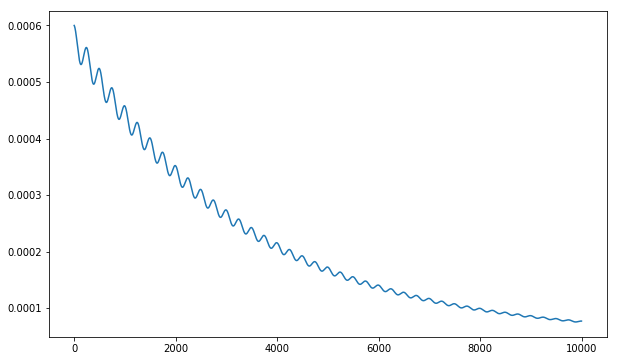

In [15]:
n_iter = 10000

def sinusoidal_exp_LR(n_iter):
    xp = np.arange(0, n_iter)
    
    f = 20
    A = 5e-4
    alpha = 0.001 # 
    threshold = 0.1*A

    LR = A*(np.exp(- alpha*xp)+0.2*np.cos(f*2*np.pi/n_iter*xp)**2) + threshold
    
    return LR

def damped_exp_LR(n_iter):
    xp = np.arange(0, n_iter)
    
    f = 20
    A = 5e-4
    alpha = 0.0003 #감쇠상수
    gamma = 0.1
    threshold = 0.1*A
    
    exp = np.exp(- alpha*xp)
    damped_comp = np.cos(f*2*np.pi/n_iter*xp)**2

    LR = A*exp*(1 + gamma*damped_comp) + threshold
    
    return LR

D = damped_exp_LR(n_iter)

print(np.max(D))
print(np.min(D))

plt.figure(figsize=(10, 6))
plt.plot(D)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(D)
# plt.xlim([1000, 1200])
# plt.show()

In [16]:
def get_and_append_metric(true, pred, metric_list, metric = ''):
    if metric == 'accuracy':
        accr = np.mean(np.equal(true, pred))
        metric_list.append(accr)
    elif metric == "sensitivity":
        fn_idx = np.where(true - pred == 1)[0]
        tp_idx = np.setxor1d(np.where(true == 1), fn_idx)
        if len(tp_idx) != 0:
            sens = len(tp_idx)/(len(tp_idx) + len(fn_idx))
            metric_list.append(sens)
    elif metric == "specificity":  
        fp_idx = np.where(true - pred == -1)[0]
        tn_idx = np.setxor1d(np.where(true == 0), fp_idx)
        if len(tn_idx) != 0:
            spec = len(tn_idx)/(len(tn_idx) + len(fp_idx))
            metric_list.append(spec)      

# Training

In [17]:
a

In [26]:
LR_func = tf.placeholder(tf.float32)
LR_de = damped_exp_LR(10000)

n_batch = 50 # x2
n_cal = 10
n_prt = 100

n_iter = 0
# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)
optm = tf.train.AdamOptimizer(LR_func).minimize(loss)
con = Contents()

loss_train, accr_train, sens_train, spec_train = [], [], [], []
loss_valid, accr_valid, sens_valid, spec_valid = [], [], [], []

early_stopping = False

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

con.table()

while True:
     
    n_iter += 1
    
    n_train_x, n_train_y = random_minibatch(neg_train_x, neg_train_y, batch_size = n_batch)
    h_train_x, h_train_y = random_minibatch(H_train_x, H_train_y, batch_size = n_batch)
    
    train_x = np.vstack([n_train_x, h_train_x])
    train_y = np.vstack([n_train_y, h_train_y])
    
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0': True, LR_func : LR_de[n_iter]})
    
    if n_iter % n_cal == 0:
        cost, prob = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0': False})
        pred = np.argmax(prob, axis = 1)
        true = np.argmax(train_y, axis = 1)
        
        loss_train.append(cost)
        get_and_append_metric(true, pred, accr_train, 'accuracy')
        get_and_append_metric(true, pred, sens_train, 'sensitivity')
        get_and_append_metric(true, pred, spec_train, 'specificity')
        
        n_valid_x, n_valid_y = random_minibatch(neg_valid_x, neg_valid_y, batch_size = n_batch)
        h_valid_x, h_valid_y = random_minibatch(H_valid_x, H_valid_y, batch_size = n_batch)

        valid_x = np.vstack([n_valid_x, h_valid_x])
        valid_y = np.vstack([n_valid_y, h_valid_y])
        
        cost_v, prob_v = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0': False})

        pred_v = np.argmax(prob_v, axis = 1)
        true_v = np.argmax(valid_y, axis = 1)
        loss_valid.append(cost_v)
        get_and_append_metric(true_v, pred_v, accr_valid, 'accuracy')
        get_and_append_metric(true_v, pred_v, sens_valid, 'sensitivity')
        get_and_append_metric(true_v, pred_v, spec_valid, 'specificity')
        
        if n_iter % n_prt == 0:
            con.prt_evl()
        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'NH_T_{0}_{1:04d}_val_sen_{2:.2f}_val_loss_{3:.5f}'.format(nowDatetime,n_iter, sens_valid[-1]*100, loss_valid[-1])
            saver.save(sess, model_path + model_name)
    if n_iter == 7000:
        break
#         if n_iter > 2000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     con.early_under()
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     con.early_over()
#                     early_stopping = True
#                     break              

train_time = int((time.time() - start_time)/60)  
con.done()

history()   
email_attached()

# sess.close()

[Iter] || Train_accr (sens) || Valid_accr (sens) || Train_loss || Valid_loss
[*100] || 64.00 % (50.00 %) || 62.00 % (54.00 %) || 0.66700608 || 0.67077219
----------------------------------------------------------------------------
[*200] || 64.00 % (60.00 %) || 74.00 % (76.00 %) || 0.63496649 || 0.58128244
----------------------------------------------------------------------------
[*300] || 77.00 % (80.00 %) || 70.00 % (68.00 %) || 0.55803436 || 0.55275244
----------------------------------------------------------------------------
[*400] || 67.00 % (54.00 %) || 73.00 % (68.00 %) || 0.60756677 || 0.50574654
----------------------------------------------------------------------------
[*500] || 70.00 % (40.00 %) || 66.00 % (36.00 %) || 0.56976998 || 0.57850772
----------------------------------------------------------------------------
[*600] || 76.00 % (72.00 %) || 81.00 % (68.00 %) || 0.46352878 || 0.46054700
----------------------------------------------------------------------------

KeyboardInterrupt: 

Training Time : 90 Min.
Early Stopping : False
Iteration : 7000



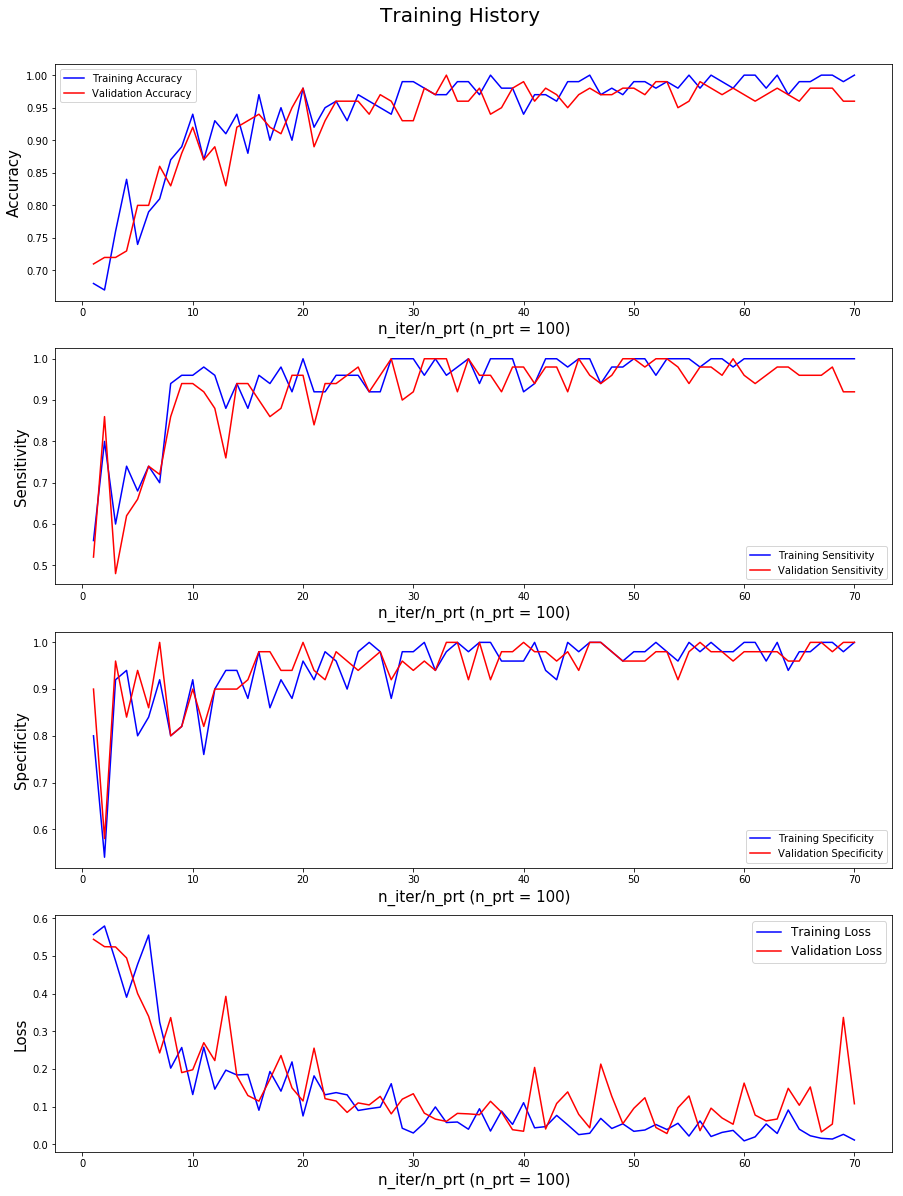

In [24]:
con = Contents()
con.done()

history()   
email_attached()

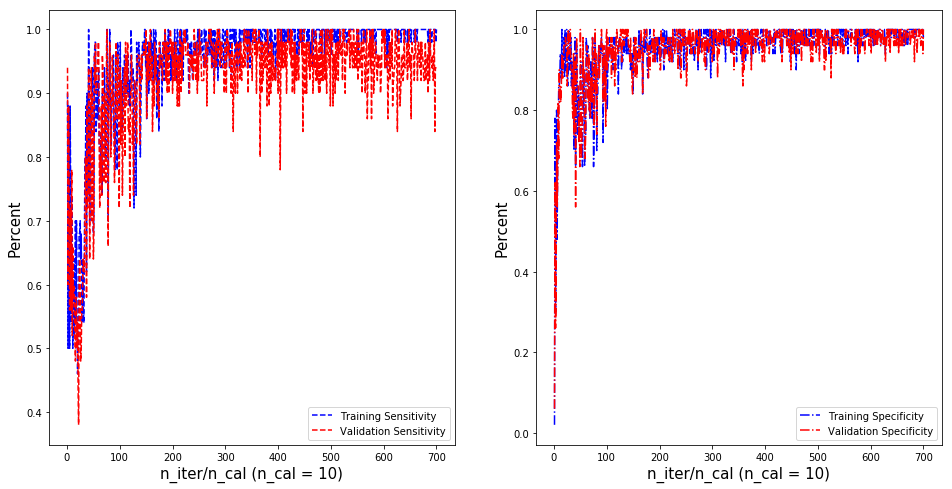

In [129]:
fig = plt.figure(figsize = (16,8))

x_axis = range(1, len(accr_train)+1)

plt.subplot(121)
plt.plot(x_axis, sens_train, 'b--', label = 'Training Sensitivity')
plt.plot(x_axis, sens_valid, 'r--', label = 'Validation Sensitivity')
plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
plt.ylabel('Percent', fontsize = 15)
plt.legend(fontsize = 10)
plt.subplot(122)
plt.plot(x_axis, spec_train, 'b-.', label = 'Training Specificity')
plt.plot(x_axis, spec_valid, 'r-.', label = 'Validation Specificity')
plt.xlabel('n_iter/n_cal (n_cal = {})'.format(n_cal), fontsize = 15)
plt.ylabel('Percent', fontsize = 15)
plt.legend(fontsize = 10)
plt.show()